In [1]:
# IMPORT LIBS
import pandas as pd
import numpy as np
import time
from glob import glob
from datetime import datetime
from logzero import logger
from IPython.display import display, HTML
import matplotlib.pyplot as plt
import timescaledb_model as tsdb
db = tsdb.TimescaleStockMarketModel('bourse', 'ricou', 'localhost', 'monmdp')

%matplotlib inline
%config InlineBackend.figure_format = 'retina'

CSS = """
.output {
    flex-direction: row;
}
"""
HTML('<style>{}</style>'.format(CSS))

Logs of timescaledb_model go to /tmp/bourse.log


In [2]:
def parse_filename(filename):
    return datetime.strptime(filename[-30:-4], "%Y-%m-%d %H:%M:%S.%f")

def erase_c(df: pd.DataFrame):
    df['last'] = df['last'].astype(str)
    df['last'] = df['last'].str.replace('(c)', '')
    df['last'] = df['last'].str.replace('(s)', '')
    df['last'] = df['last'].str.replace(' ', '')
    df['last'] = df['last'].astype(float)
    return df

def custom_sort_key(file_path):
    return file_path[-30:-4]

In [3]:
# MAIN ARGS
bourse_path = "../docker/data/boursorama"
available_years = [2020] #np.arange(2019, 2024)
markets = ["compA"] #np.array(["amsterdam", "compA", "compB", "peapme"])
companie_focus = 'ACCOR'

# Loading strategy
batch_range = 1000

# STATS
count = 0

In [4]:
# CURRENT DATA
data = {}

def store_file(files, website):
    if website.lower() != "boursorama":
        return
    #  if not db.is_file_done(filename) # Desactivated cz useless for now

    for filename in files:
        df = pd.read_pickle(filename)

        # Market
        # df['market'] = market
        # df['cid'] = cid

        # Add in final fidctionary
        data[parse_filename(filename)] = df[df.name == companie_focus]

In [5]:
# MAIN LOOP

logger.debug(f"Work in progress...")
for year in available_years:
    for market in markets:
        starting_time = time.time()
        path_pattern = f"{bourse_path}/{year}/{market}*"

        available_files = glob(path_pattern)
        available_files = sorted(available_files, key=custom_sort_key)

        #cid = int(db.raw_query(f"SELECT id FROM markets WHERE alias = '{market}'")[0][0])

        for i in range(0, len(available_files), batch_range):
            logger.debug(f"Batch: {i // batch_range + 1} of 1K elements")

            store_file(available_files[i: i + batch_range], "boursorama")

        count += len(available_files)
        logger.debug(f"{year}-{market} done on {len(available_files)} files in {time.time() - starting_time} seconds.")

logger.debug(f"Work done on {count} files, in {time.time() - starting_time} seconds.")

[D 240328 13:16:11 304718770:3] Work in progress...
[D 240328 13:16:11 304718770:15] Batch: 1 of 1K elements
[D 240328 13:16:13 304718770:15] Batch: 2 of 1K elements
[D 240328 13:16:14 304718770:15] Batch: 3 of 1K elements
[D 240328 13:16:15 304718770:15] Batch: 4 of 1K elements
[D 240328 13:16:16 304718770:15] Batch: 5 of 1K elements
[D 240328 13:16:17 304718770:15] Batch: 6 of 1K elements
[D 240328 13:16:18 304718770:15] Batch: 7 of 1K elements
[D 240328 13:16:20 304718770:15] Batch: 8 of 1K elements
[D 240328 13:16:21 304718770:15] Batch: 9 of 1K elements
[D 240328 13:16:22 304718770:15] Batch: 10 of 1K elements
[D 240328 13:16:23 304718770:15] Batch: 11 of 1K elements
[D 240328 13:16:24 304718770:15] Batch: 12 of 1K elements
[D 240328 13:16:25 304718770:15] Batch: 13 of 1K elements
[D 240328 13:16:26 304718770:20] 2020-compA done on 12470 files in 14.29504132270813 seconds.
[D 240328 13:16:26 304718770:22] Work done on 12470 files, in 14.295917272567749 seconds.


In [6]:
# CONCAT FINAL DATA
df = pd.concat(data).reset_index(level=1, drop=True)

# CLEAN DATA
erase_c(df)
df.index = pd.to_datetime(df.index)
#df.sort_index(inplace=True)
df = df[df.symbol == "1rPAC"] # HARDCODE
display(df.head(100))

,last,volume,symbol,name,market,cid
2020-01-01 09:02:02.532411,41.75,224245,1rPAC,ACCOR,compA,7
2020-01-01 09:12:01.997585,41.75,224245,1rPAC,ACCOR,compA,7
2020-01-01 09:22:01.655711,41.75,224245,1rPAC,ACCOR,compA,7
2020-01-01 09:32:02.484518,41.75,224245,1rPAC,ACCOR,compA,7
2020-01-01 09:42:01.841351,41.75,224245,1rPAC,ACCOR,compA,7
...,...,...,...,...,...,...
2020-01-02 15:52:01.995679,42.02,288362,1rPAC,ACCOR,compA,7
2020-01-02 16:02:01.652412,41.99,291701,1rPAC,ACCOR,compA,7
2020-01-02 16:12:01.974028,41.99,302603,1rPAC,ACCOR,compA,7
2020-01-02 16:22:01.759848,41.98,305313,1rPAC,ACCOR,compA,7


In [7]:
set(df.symbol)

{'1rPAC'}

In [8]:
display(df.tail(100))

,last,volume,symbol,name,market,cid
2020-12-30 10:21:01.637462,29.72,32282,1rPAC,ACCOR,compA,7
2020-12-30 10:31:01.598427,29.78,18088,1rPAC,ACCOR,compA,7
2020-12-30 10:41:01.491035,29.73,35302,1rPAC,ACCOR,compA,7
2020-12-30 10:51:02.377788,29.64,44810,1rPAC,ACCOR,compA,7
2020-12-30 11:01:01.745026,29.65,46745,1rPAC,ACCOR,compA,7
...,...,...,...,...,...,...
2020-12-31 17:11:01.942676,29.60,130803,1rPAC,ACCOR,compA,7
2020-12-31 17:21:02.255744,29.60,130803,1rPAC,ACCOR,compA,7
2020-12-31 17:31:01.759065,29.60,130803,1rPAC,ACCOR,compA,7
2020-12-31 17:41:01.715188,29.60,130803,1rPAC,ACCOR,compA,7


In [9]:
# WORKING ON daystocks
daystocks = df.copy()

# Convert the index to datetime if it's not already in datetime format
daystocks.reset_index(names="timestamp", inplace=True)

# Group by 'name' column
grouped = daystocks.groupby(['name', daystocks['timestamp'].dt.date])

# Apply aggregations
result_daystocks = grouped.agg({
    "timestamp": "first",
    'last': ['first', 'last', np.min, np.max],
    'volume': np.sum,
})

# Rename columns for better clarity
result_daystocks.columns = ['date', 'open', 'close', 'low', 'high', 'volume'] # ADD 'date',
result_daystocks["date"] = result_daystocks["date"].dt.date

print("len ", len(result_daystocks))

len  233


/tmp/ipykernel_30590/1499633122.py:11: FutureWarning: The provided callable <function min at 0x79b5447a1b40> is currently using SeriesGroupBy.min. In a future version of pandas, the provided callable will be used directly. To keep current behavior pass the string "min" instead.
  result_daystocks = grouped.agg({
/tmp/ipykernel_30590/1499633122.py:11: FutureWarning: The provided callable <function max at 0x79b5447a1a20> is currently using SeriesGroupBy.max. In a future version of pandas, the provided callable will be used directly. To keep current behavior pass the string "max" instead.
  result_daystocks = grouped.agg({
/tmp/ipykernel_30590/1499633122.py:11: FutureWarning: The provided callable <function sum at 0x79b5447a13f0> is currently using SeriesGroupBy.sum. In a future version of pandas, the provided callable will be used directly. To keep current behavior pass the string "sum" instead.
  result_daystocks = grouped.agg({


In [10]:
display(result_daystocks)

date   open  close    low   high    volume
name  timestamp                                                   
ACCOR 2020-01-01  2020-01-01  41.75  41.75  41.75  41.75  12109230
      2020-01-02  2020-01-02  42.13  41.76  41.76  42.23  11698569
      2020-01-03  2020-01-03  41.60  41.25  41.02  41.60  15381946
      2020-01-06  2020-01-06  40.75  40.25  39.90  40.75  24465164
      2020-01-07  2020-01-07  40.27  40.35  39.96  40.62  21960781
...                      ...    ...    ...    ...    ...       ...
      2020-12-25  2020-12-25  29.33  29.33  29.33  29.33   5800086
      2020-12-28  2020-12-28  29.60  29.55  29.50  29.91   4843781
      2020-12-29  2020-12-29  29.77  29.76  29.76  30.51  10017540
      2020-12-30  2020-12-30  29.90  30.00  29.55  30.03   5258956
      2020-12-31  2020-12-31  29.72  29.60  29.60  29.76   3895268

[233 rows x 6 columns]

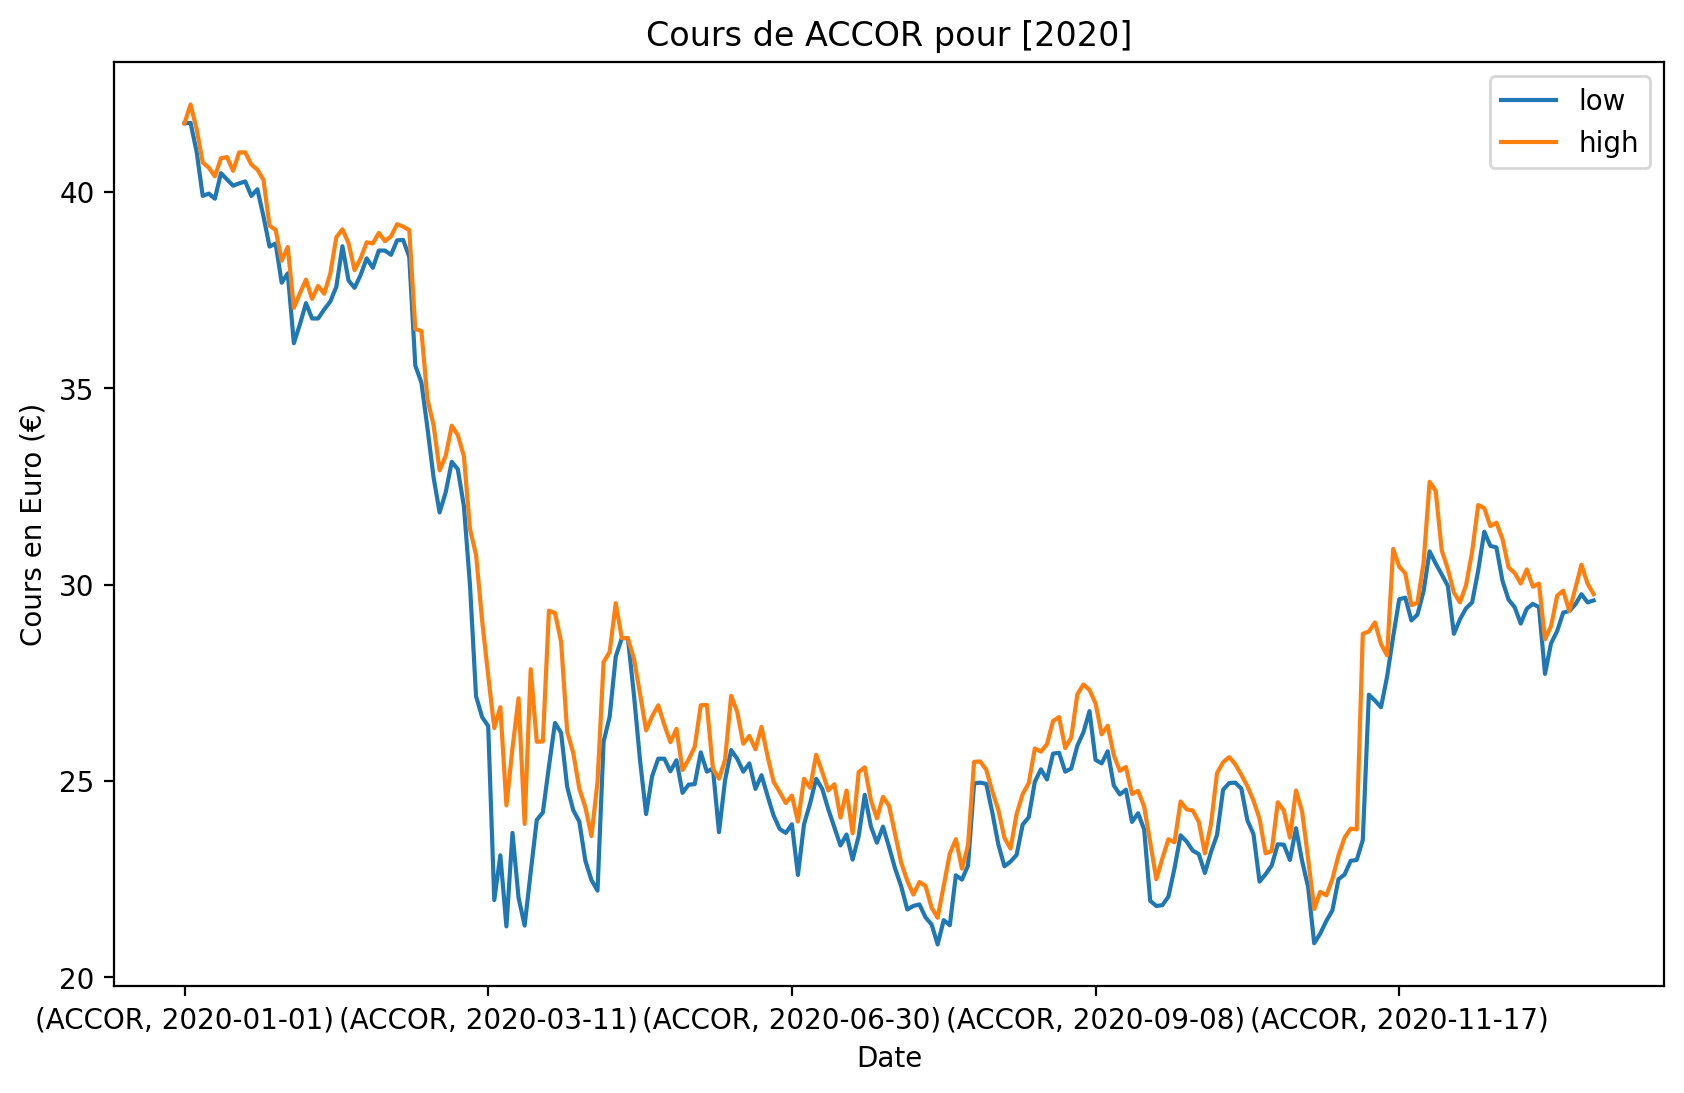

In [11]:
show_data = ["low", "high"]
def plot_daystocks(dataframe):
    copy = dataframe.copy()
    copy.plot(y=show_data, figsize=(10,6), title=f"Cours de {companie_focus} pour {available_years}")
    plt.xlabel("Date")
    plt.ylabel("Cours en Euro (€)")
    plt.show()

plot_daystocks(result_daystocks)

In [12]:
# Testing

"""test = df[df.name == "WORLDLINE"]
print(test["last"][1])
print(test["last"][-1])
print(test["last"].min())
print(test["last"].max())
print(test["volume"].sum())"""

'test = df[df.name == "WORLDLINE"]\nprint(test["last"][1])\nprint(test["last"][-1])\nprint(test["last"].min())\nprint(test["last"].max())\nprint(test["volume"].sum())'

In [13]:
compagnies_df = db.df_query('SELECT id, symbol FROM companies', chunksize=None)
display(compagnies_df)

,id,symbol


In [14]:
stock_df = df[['symbol', 'last', 'volume']].copy().reset_index(names='date')

# stock_df = stock_df[stock_df['volume']] # MAX INT?
stock_df = stock_df.merge(compagnies_df, left_on='symbol', right_on='symbol', how='left')
stock_df.rename(columns={'last': 'value', 'id': 'cid'}, inplace=True)
stock_df.drop(columns=['symbol'], inplace=True)

# db.df_write(stock_df, 'stocks', commit=True, index=False)
display(stock_df)

,date,value,volume,cid
0,2020-01-01 09:02:02.532411,41.75,224245,NaN
1,2020-01-01 09:12:01.997585,41.75,224245,NaN
2,2020-01-01 09:22:01.655711,41.75,224245,NaN
3,2020-01-01 09:32:02.484518,41.75,224245,NaN
4,2020-01-01 09:42:01.841351,41.75,224245,NaN
...,...,...,...,...
12465,2020-12-31 17:11:01.942676,29.60,130803,NaN
12466,2020-12-31 17:21:02.255744,29.60,130803,NaN
12467,2020-12-31 17:31:01.759065,29.60,130803,NaN
12468,2020-12-31 17:41:01.715188,29.60,130803,NaN


In [15]:
#mid = int(db.raw_query('SELECT id FROM markets WHERE alias = %s', market))